In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

import psutil
from joblib import Parallel, delayed

from scipy.optimize import differential_evolution

from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# product, time_reso = 'IMERG', '1dy'

# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'MSWEP', '3h'
product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'SM2RAIN', '1dy'

yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : CMORPH_3h.json
Number of threads: 20
Neighborhood area: 5x5



In [16]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [17]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [18]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1.5, lat_min-1.5), lon=slice(lon_min-1.5, lon_max+1.5))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1.5, lat_max+1.5), lon=slice(lon_min-1.5, lon_max+1.5))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

# year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc


<xarray.Dataset> Size: 62MB
Dimensions:  (time: 32144, lat: 20, lon: 24)
Coordinates:
  * lat      (lat) float32 80B 43.12 43.38 43.62 43.88 ... 47.38 47.62 47.88
  * lon      (lon) float32 96B 9.125 9.375 9.625 9.875 ... 14.38 14.62 14.88
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 62MB ...
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [29]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

<xarray.Dataset> Size: 568B
Dimensions:  (lat: 10, lon: 12)
Coordinates:
  * lat      (lat) float32 40B 44.62 44.88 45.12 45.38 ... 46.38 46.62 46.88
  * lon      (lon) float32 48B 10.62 10.88 11.12 11.38 ... 12.88 13.12 13.38
Data variables:
    PRE      (lat, lon) float32 480B 1.853 1.702 1.577 ... 1.857 2.041 2.203

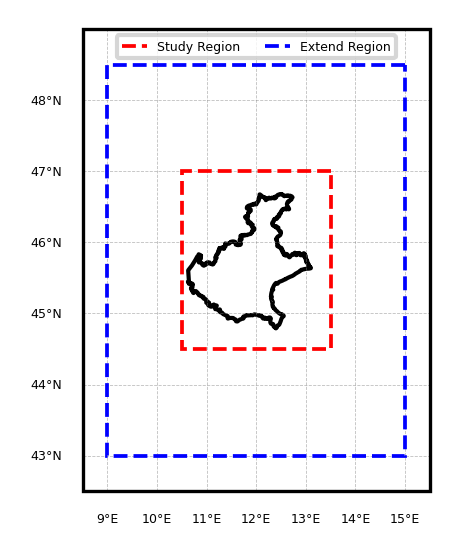

In [21]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-2, lon_max+2, lat_min-2, lat_max+2],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1.5,lat_max+1.5),(lon_min-1.5)-(lon_max+1.5),(lat_min-1.5)-(lat_max+1.5),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=3,ncols=2,loc='upper center')

In [22]:
def gamma_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
    if time_reso == '3h':
        PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
        BOX = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, PARAM['npix'])
    elif time_reso == '1dy':
        BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])
        PRE_daily = DATA_in
    else:
        print(f'Erorr: {time_reso} not valid')
        return None

    print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")
    
    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data
    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = ART_down.fit_yearly_weibull_update(
                    IMERG_pixel_1dy_xr, 
                    thresh=PARAM['thresh'], 
                    maxmiss=PARAM['maxmiss'])
    
    vdist, vcorr = ART_pre.autocorrelation_neighborhood_v2(
                    BOX, 
                    time_reso, 
                    param['target_t'], 
                    param['thresh'])
    
    mask = ~np.isnan(vdist) & ~np.isnan(vcorr)
    vdist, vcorr = np.array(vdist)[mask], np.array(vcorr)[mask]

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation
    
    bounds = [(0.0, 25.0),(0, 0.3)] # NEW LIMITS USING ALL CORRELATIONS FUNCTION IN VENETO

    def myfun(pardown):
        return ART_down.myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    resmin = differential_evolution(
                myfun,
                bounds,
                disp=True,
                tol=0.03,
                atol=0.03,
                workers=1,
                updating='deferred'
            )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    gamma = ART_down.gamma_manual(IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        (param1, param2), 
                        acf=PARAM['acf'])

    return gamma


In [23]:
def compute_for_point(lat_idx, lon_idx):
    return gamma_3h_1dy(PRE_data, time_reso, lats[lat_idx], lons[lon_idx], param)

Resource = []

start_time = time.time()

results = Parallel(n_jobs=param['GAMMA_cores'])(
    delayed(compute_for_point)(la, lo) for la in ndices_lat for lo in ndices_lon
    )

end_time = time.time()

elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
# memory_consumed = psutil.virtual_memory().used / 1024 ** 3

print(f"Elapsed time: {elapsed_minutes:.2f} minutes")
# print(f"Memory consumed: {memory_consumed:.3f} GB")

Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
differential_evolution step 1: f(x)= 0.09404979164778199
differential_evolution step 1: f(x)= 0.05064328109818475
differential_evolution step 1: f(x)= 0.07399884027648354
differential_evolution step 1: f(x)= 0.09270789262608471
differential_evolution step 1: f(x)= 0.10672191107135418
differential_evolution step 1: f(x)= 0.07920047606347715
differential_evolution step 1: f(x)= 

In [24]:
GAMMA_VENETO = np.array(results).reshape(len(ndices_lat), len(ndices_lon))

In [25]:
#Export beta as netcdf
GAMMA_xr = xr.Dataset(data_vars={"GAMMA": (("lat","lon"), GAMMA_VENETO.data)},
                    coords={'lat': lats[ndices_lat], 'lon': lons[ndices_lon]},
                    attrs=dict(description=f"GAMMA of {product} for Veneto region limited as 10.5E to 13.5E and 44.5N to 47N"))

GAMMA_xr.GAMMA.attrs["units"] = "dimensionless"
GAMMA_xr.GAMMA.attrs["long_name"] = "Relation between Origin and Tarjet wet fraction"
GAMMA_xr.GAMMA.attrs["origname"] = "GAMMA"

GAMMA_xr.lat.attrs["units"] = "degrees_north"
GAMMA_xr.lat.attrs["long_name"] = "Latitude"

GAMMA_xr.lon.attrs["units"] = "degrees_east"
GAMMA_xr.lon.attrs["long_name"] = "Longitude"

In [26]:
GAMMA_xr

<xarray.Dataset> Size: 1kB
Dimensions:  (lat: 10, lon: 12)
Coordinates:
  * lat      (lat) float32 40B 44.62 44.88 45.12 45.38 ... 46.38 46.62 46.88
  * lon      (lon) float32 48B 10.62 10.88 11.12 11.38 ... 12.88 13.12 13.38
Data variables:
    GAMMA    (lat, lon) float64 960B 0.9196 0.9131 0.9102 ... 0.9055 0.9101
Attributes:
    description:  GAMMA of CMORPH for Veneto region limited as 10.5E to 13.5E...

In [27]:
GAMMA_out = os.path.join(dir_base,'2_GAMMA',f'VENETO_GAMMA_{product}_{time_reso}_{yy_s}_{yy_e}.nc')
print(f'Export PRE data to {GAMMA_out}')
GAMMA_xr.to_netcdf(GAMMA_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/2_GAMMA/VENETO_GAMMA_CMORPH_3h_2002_2012.nc


Export figure to: ../figures/GAMMA/VENETO_CMORPH_mean_gamma_3h_cores_20_npix_2.png


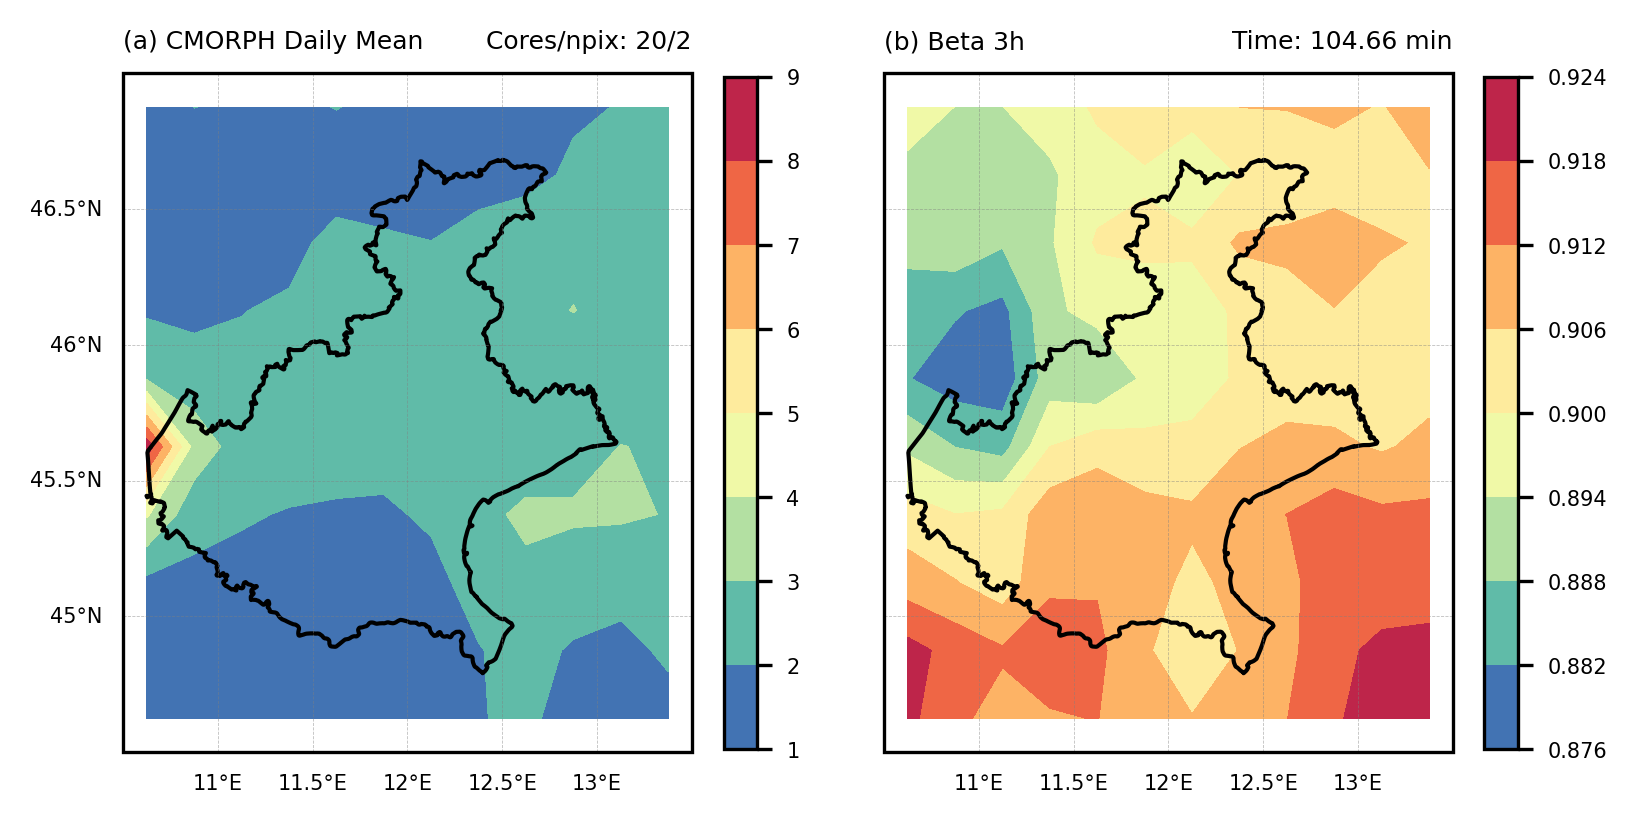

In [30]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d_ref, lat2d_ref, PRE_mean.PRE.values, cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=5)

ax1.set_title(f'(a) {product} Daily Mean', fontsize=6, loc='left')
ax1.set_title(f'Cores/npix: {param['BETA_cores']}/{NEIBHR}', fontsize=6, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d_ref, lat2d_ref, GAMMA_VENETO, cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=5)

# Variance function between two scales (Gamma)
# Intermitency function between two scales (BETA)
ax1.set_title(f'(b) Beta {time_reso}', fontsize=6, loc='left')
ax1.set_title(f'Time: {elapsed_minutes:.2f} min', fontsize=6, loc='right')

salida = os.path.join('..','figures','GAMMA',f'VENETO_{product}_mean_gamma_{time_reso}_cores_{param['BETA_cores']}_npix_{NEIBHR}.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [28]:
playsound("../sound/HOMER_DOH.mp3")